# TP7 - Réduction de dimensions

Peut-on déduire le genre d'un film à son poster ? Nous nous proposons d'explorer cela en exploitant la réduction de dimension. On s'appuie sur le dataset publié sur [Kaggle](https://www.kaggle.com/datasets/raman77768/movie-classifier) lui-même extrait de ce [dataset](https://www.cs.ccu.edu.tw/~wtchu/projects/MoviePoster/index.html) construit pour répondre à la problématique que nous nous sommes posé, initialement avec des réseaux de neurones.

Commençons par construire un dataset exploitable pour nous. Nous allons devoir :
1. Charger l'image et son identifiant
2. Modifier l'image de sorte qu'elle soit de taille uniforme
3. Applatir l'image pour former le dataset tabulaire final

L'identifiant nous servira plus tard. Nous choisissons ici la taille standard (50, 50, 3) puisque les images sont en couleurs, cela nous amènera à un dataset de taille $75\times75\times3=7500$. Commençons par construire une fonction qui nous permettra de charger les images.

In [1]:
from PIL import Image


path = "Multi_Label_dataset/Images"


def get_image(id, path=path):
    image_path = path + "/" + id + ".jpg"
    image = Image.open(image_path)
    return image

Construisons maintenant le dataset.

In [2]:
import numpy as np
import pandas as pd
import os

dataset = []
images = os.listdir(path)
for file in images:
    image_path = path + "/" + file
    image = Image.open(image_path).resize((50, 50))
    dataset.append(np.array(image).flatten())

df = pd.DataFrame(dataset)
df["Id"] = [image.replace(".jpg", "") for image in images]
df.head()

,0,1,2,3,4,5,6,7,8,9,...,7491,7492,7493,7494,7495,7496,7497,7498,7499,Id
0,4,5,4,3,3,3,5,4,4,3,...,42,42,42,36,36,36,12,12,12,tt2321249
1,12,13,8,12,13,8,14,15,10,15,...,1,1,1,2,2,2,3,3,3,tt1477076
2,75,97,108,62,90,103,62,92,105,63,...,245,244,245,245,245,247,247,246,249,tt0089504
3,248,248,248,248,248,248,248,248,248,248,...,248,247,242,248,247,242,248,247,242,tt0086637
4,70,36,141,69,35,140,70,36,140,70,...,112,118,116,71,73,72,64,66,65,tt0131857


Nous allons travailler avec l'algorithme UMAP, qui s'appuie sur une descente de gradient. Pour simplifier cette étape, nous proposons de préparer la matrice en conséquence.

**Consigne** : Après avoir créer une matrice *X* qui correspond à *df* sans la colonne *Id*, standardiser les données à l'aide de la classe [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

In [3]:
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=["Id"], axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)

**Consigne** : Calculer les coordonnées dans la nouvelle base de chaque observations avec l'algorithme [UMAP](https://umap-learn.readthedocs.io/en/latest/). On précisera que l'on souhaite obtenir uniquement deux dimensions finale.

In [4]:
from umap.umap_ import UMAP

model = UMAP(n_neighbors=50, min_dist=0.1, n_components=2)
embedding = model.fit_transform(X)

L'objectif a présent est d'exploiter la nouvelle base de deux manières :
1. **Visualiser** l'ensemble des affiches sur un même graphique, et leur répartition selon les genre
2. **Identifier** les affiches les plus proches selon la nouvelle base


## Objectif 1: Visualiser
Pour réussir le premier objectif, exploitons le dataset qui spécifie les genres.

In [5]:
df_categories = pd.read_csv("Multi_Label_dataset/train.csv")
df_categories.head()

,Id,Genre,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,N/A,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,tt0086425,"['Comedy', 'Drama']",0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,tt0085549,"['Drama', 'Romance', 'Music']",0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,tt0086465,['Comedy'],0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,tt0086567,"['Sci-Fi', 'Thriller']",0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,tt0086034,"['Action', 'Adventure', 'Thriller']",1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Nous avons à nouveau la colonne *Id* présente pour pouvoir faire la jointure. Notons que nous n'avons pas un unique genre pour chaque films. Ajoutons à notre *embedding* les informations de cette base de données.

**Consigne** : Définir une fonction `augment_embedding` qui prend en paramètre un *embedding* *X*. Elle ajoutera à cet embedding les identifiants issus du dataset *df* pour ensuite faire la jointure avec le dataset *df_categories*. On utilisera la méthode [`merge`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html )pour la jointure, et la méthode [`dropna`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html) pour supprimer les affiches dont on ne connait pas le genre.

In [6]:
def augment_embedding(X):
    embedding = pd.DataFrame(X, columns=["Dimension 1", "Dimension 2"])
    embedding["Id"] = df["Id"]
    embedding = embedding.merge(df_categories, on="Id", how="left")
    embedding = embedding.dropna()
    return embedding

embedding = augment_embedding(embedding)

Nous avons maintenant la capacité de visualiser l'embedding et d'y projeter un genre.

**Consigne** : Définir la fonction `plot_embedding_genre` qui prend en paramètre :
* *embedding*: un dataframe qui correspond à l'embedding apprit
* *genre*: chaîne de caractère qui correspond à une des colonnes de genre
* *title*: chaîne de caractère valant *None* par défaut, et qui permet de personnaliser le titre, sinon n'en affiche pas
La fonction affichera le scatter plot de chacune des affiches selon l'embedding apprit, et afficher de deux couleurs différentes les observations associées au genre d'intérêt

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='white')

def plot_embedding_genre(embedding, genre, title=None):
    temp_genre = embedding.loc[embedding[genre] == 1., ["Dimension 1", "Dimension 2"]]
    temp_nongenre = embedding.loc[embedding[genre] == 0, ["Dimension 1", "Dimension 2"]]

    plt.scatter(temp_nongenre["Dimension 1"], temp_nongenre["Dimension 2"], alpha=0.3, s=1, color=sns.color_palette()[0])
    plt.scatter(temp_genre["Dimension 1"], temp_genre["Dimension 2"], alpha=0.8, s=5, color=sns.color_palette()[1], label=genre)
    plt.legend()
    sns.despine()
    if not(title is None):
        plt.title(title)
    plt.show()

**Consigne** : Appliquer la fonction `plot_embedding_genre` sur plusieurs genre pour visualiser la base de données.

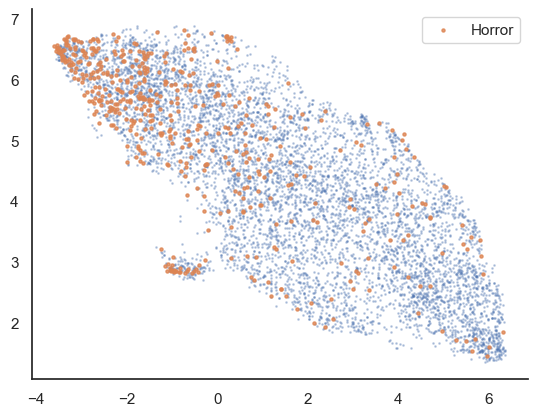

In [8]:
genre = "Horror"
plot_embedding_genre(embedding, genre)

Jusqu'ici nous avons travailler avec les valeurs par défaut de l'algorithme UMAP, et donc visualiser qu'un unique embedding possible.

**Consigne** : Définir la fonction `learn_embedding` qui prend en paramètre les paramètres à transmettre à l'algorithme UMAP. Elle renverra un embedding apprit avec les paramètres renseigné pour UMAP, et il sera augmenté avec la fonction `augment_embedding`.

In [9]:
def learn_embedding(**parameters):
    model = UMAP(**parameters)
    embedding = model.fit_transform(X)
    embedding = augment_embedding(embedding)
    return embedding

**Consigne** : Visualiser, pour un même genre, différent paramètre de UMAP.

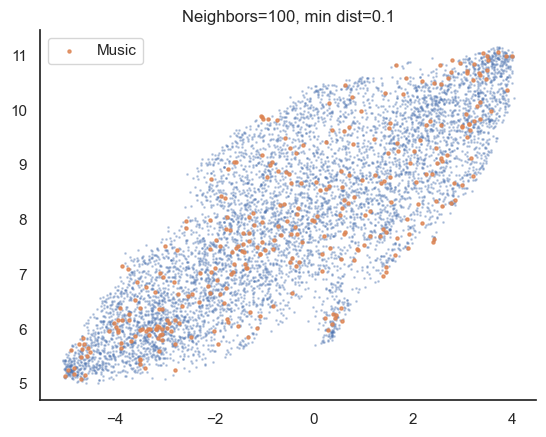

In [10]:
genre = "Music"
embedding = learn_embedding(n_neighbors=100, min_dist=0.1, n_components=2)
plot_embedding_genre(embedding, genre, title="Neighbors=100, min dist=0.1")

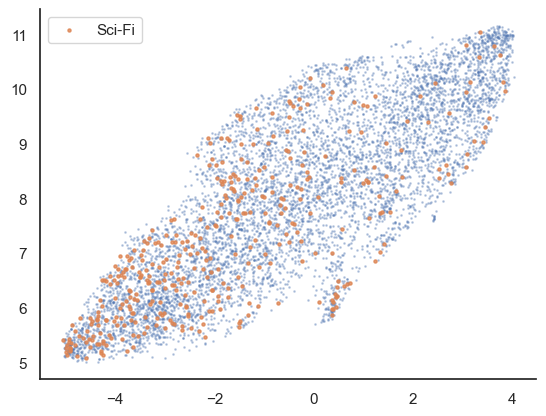

In [11]:
plot_embedding_genre(embedding, genre="Sci-Fi")

## Objectif 2: Identifier

On souhaite à présent identifier pour une affiche donnée les affiches les plus proches. Pour définir *l'affiche la plus proche* on décide de travailler avec un embedding apprit, et deux possibilités de distance.
* **Distance euclidienne** : la distance classique, celle qui correspond au monde physique. Pour deux vecteurs $u, v \in \mathbb{R}^n$, la distance euclidienne $d$ est :
$$d(u, v) = \sqrt{\sum_{i=1}^n (u_i - v_i)^2}$$
* **Distance cosinus** : mesure de similarité entre deux vecteurs se basant sur l'angle entre les deux vecteurs. Pour deux vecteurs $u, v \in \mathbb{R}^n$, la distance cosinus $d$ est :
$$d(u, v) = 1 - \frac{\langle u, v\rangle}{\|u\|\|v\|}$$

**Consigne** : Définir les fonctions suivante, qui prendront en paramètres un embedding de dimension 2 et une observation:
1. `euclidean_distance`: renvoie la distance euclidienne entre l'observation et l'ensemble de l'embedding
2. `cosinus_distance`: renvoie la distance cosinus entre l'observation et l'ensemble de l'embedding

In [12]:
def euclidean_distance(embedding, observation):
    distances = ((embedding["Dimension 1"] - observation["Dimension 1"])**2 + (embedding["Dimension 2"] - observation["Dimension 2"])**2)**0.5
    return distances


def cosinus_distance(embedding, observation):
    dot_product = embedding["Dimension 1"] * observation["Dimension 1"] + embedding["Dimension 2"] * observation["Dimension 2"]
    norm_embedding = (embedding["Dimension 1"]**2 + embedding["Dimension 2"]**2)**0.5
    norm_observation = (observation["Dimension 1"]**2 + observation["Dimension 2"]**2)**0.5
    distances = 1 - dot_product / (norm_embedding * norm_observation)
    return distances

**Consigne** : Définir la fonction `view_neighbors` qui prendra en paramètre 
* *embedding*: une matrice qui correspond à l'embedding d'intérêt
* *row_index*: un entier qui correspond à l'indice de l'affiche d'intérêt
* *n_neighbors*: le nombre de voisin que l'on souhaite visualiser, par défaut 2
* *distance*: fonction qui correspond à la distance que l'on souhaite utiliser
* *figsize*: un tuple qui permet de contrôler la taille du graphique généré

Elle renverra l'affiche initiale et les *n_neighbors* associés selon la distance choisie pour l'embedding précisé. On pourra utiliser la méthode [`nsmallest`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.nsmallest.html) et la fonction `get_image` pour afficher les images dans leurs format initial.

In [13]:
def view_neighbors(embedding, row_index, n_neighbors=2, distance=euclidean_distance, figsize=(14, 6)):

    row = embedding.iloc[row_index, ]
    distances = distance(embedding, row)
    closest_indices = distances.nsmallest(n_neighbors+1).index
    neighbors = embedding.loc[closest_indices].reset_index()
    
    plt.figure(figsize=figsize)
    for index in range(n_neighbors+1):
        row = neighbors.iloc[index, ]
        image = get_image(row["Id"])
        genre = row["Genre"].replace("[", "").replace("]", "").replace("'", "")
        if row["index"] == row_index:
            title = f"Source image : {genre}"
        else:
            title = f"Neighbor : {genre}"
        
        plt.subplot(1, n_neighbors+1, index+1)
        plt.imshow(image)
        plt.title(title)
    
    plt.show()

**Consigne** : Exploiter la fonction `view_neighbors` et juger de la qualité de l'embedding.

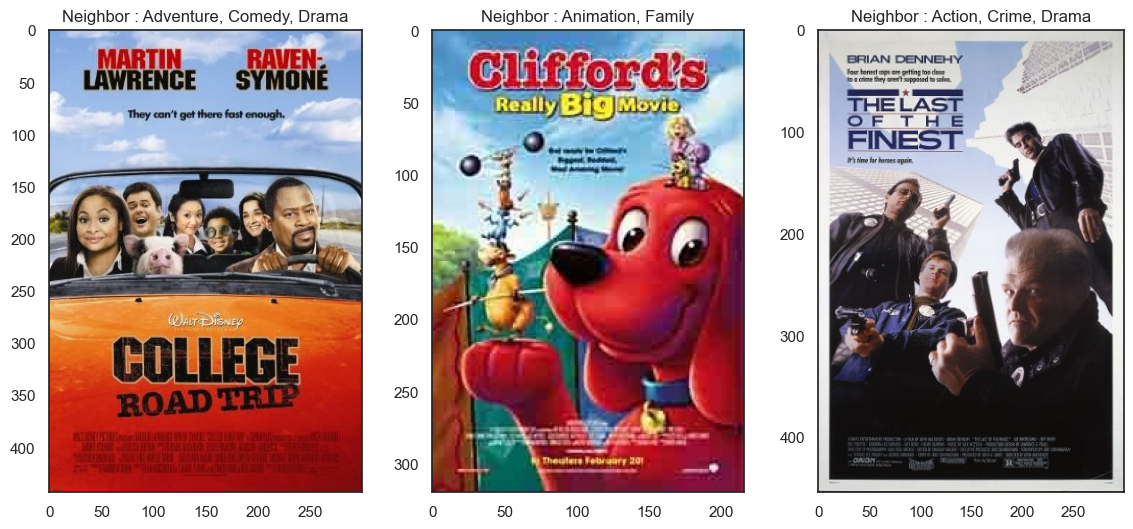

In [21]:
view_neighbors(embedding, 2020)